# Filtering signal in azimuthal space

Usually, diffraction signal presents a polar symmetry, this means all pixel with the same azimuthal angle (χ) have similar intensities. The best way to exploit this is to take the mean, what is called *azimuthal average*. But the average is very sensitive to outlier, like gaps, missing pixels, shadows, cosmic rays or reflection coming from larger crystallite. In this tutorial we will see two alternative ways to remove those unwanted signal and focus on the majority of pixels: **sigma clipping** and **median filtering**.

In [11]:
import os
import time
os.environ["PYOPENCL_COMPILER_OUTPUT"]="0"
import pyFAI
print(f"pyFAI version: {pyFAI.version}")

pyFAI version: 2025.11.0-dev0


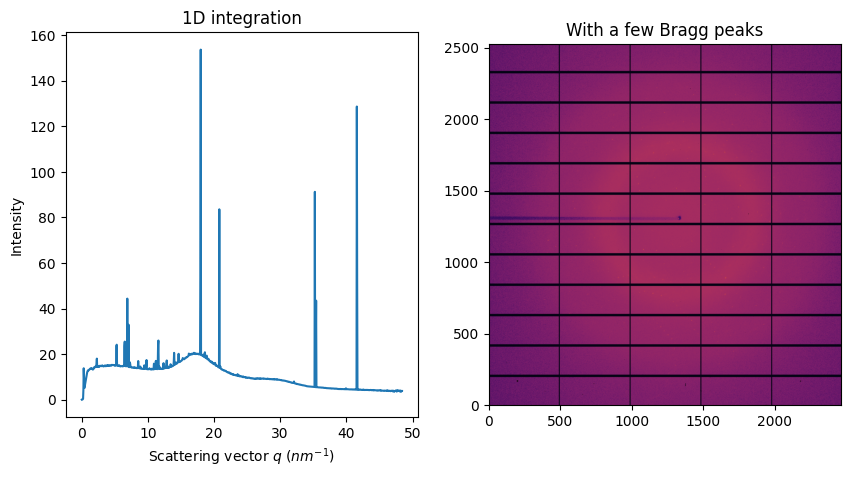

In [2]:
%matplotlib inline
from matplotlib.pyplot import subplots
from pyFAI.gui import jupyter
import numpy, fabio, pyFAI
from pyFAI import benchmark
from pyFAI.test.utilstest import UtilsTest

figsize = (10,5)

ai = pyFAI.load(UtilsTest.getimage("Pilatus6M.poni"))
img = fabio.open(UtilsTest.getimage("Pilatus6M.cbf")).data
fig, ax = subplots(1, 2, figsize=figsize)
jupyter.display(img, ax=ax[1])
jupyter.plot1d(ai.integrate1d(img, 1000), ax=ax[0])
ax[1].set_title("With a few Bragg peaks");

## Azimuthal sigma-clipping

The idea is to discard pixels which look like outliers in the distribution of all pixels contributing to a single azimuthal bin.
It requires an error model like *poisson* but it has been proven to be better to use the variance in the given azimuthal ring.
All details are available in this publication: https://doi.org/10.1107/S1600576724011038 also available at https://doi.org/10.48550/arXiv.2411.09515 

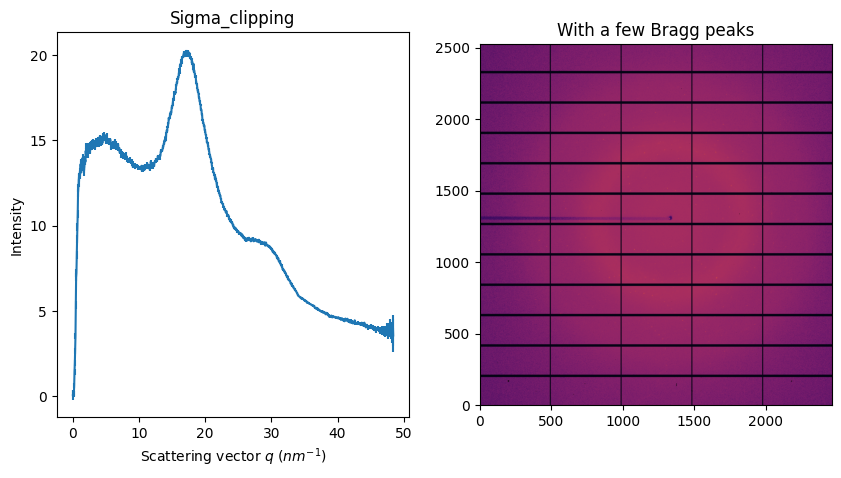

In [3]:
fig, ax = subplots(1, 2, figsize=figsize)
jupyter.display(img, ax=ax[1])
jupyter.plot1d(ai.sigma_clip(img, 1000, error_model="hybrid", method=("no", "csr", "cython")), ax=ax[0])
ax[1].set_title("With a few Bragg peaks")
ax[0].set_title("Sigma_clipping");

Of course, *sigma-clip* takes several extra parameters like the number of iterations to perform, the cut-off, the error model, ... 
There are alo a few limitation: 
* The algorithm needs to be the CSR-sparse matrix multiplication: since several integration are needed, it makes no sense to use an histogram based algorithm.
* The algorithm is available with any implementation: Python (using scipy.saprse), Cython and OpenCL, and it runs just fine on GPU.
* Sigma-clipping is incompatible with any kind of pixel splitting: With pixel splitting, a single pixel can contribute to several azimuthal bins and discarding a pixel in one ring could disable it in the neighboring ring (or not, since bins are processed in parallel).

### Sigma-clipping performances:

In [4]:
method = ["no", "csr", "cython"]

In [5]:
%%time 
perfs_integrate_python = {}
perfs_integrate_cython = {}
perfs_integrate_opencl = {}
perfs_sigma_clip_python = {}
perfs_sigma_clip_cython = {}
perfs_sigma_clip_opencl = {}

for ds in pyFAI.benchmark.PONIS:
    ai = pyFAI.load(UtilsTest.getimage(ds))
    if ai.wavelength is None: ai.wavelength=1.54e-10
    img = fabio.open(UtilsTest.getimage(pyFAI.benchmark.datasets[ds])).data
    size = numpy.prod(ai.detector.shape)
    print(ds)
    print("     Cython")
    meth = tuple(method)
    nbin = max(ai.detector.shape)
    print("     * integrate ", end="")
    perfs_integrate_cython[size] = %timeit -o ai.integrate1d(img, nbin, method=meth)
    print("     * sigma-clip", end="")
    perfs_sigma_clip_cython[size] = %timeit -o ai.sigma_clip(img, nbin, method=meth, error_model="azimuthal")
    print("     Python")
    meth = tuple(method[:2]+["python"])
    print("     * integrate ", end="")
    perfs_integrate_python[size] = %timeit -o ai.integrate1d(img, nbin, method=meth)
    print("     * sigma-clip", end="")
    perfs_sigma_clip_python[size] = %timeit -o ai.sigma_clip(img, nbin, method=meth, error_model="azimuthal")

    print("     OpenCL")
    meth = tuple(method[:2]+["opencl"])
    print("     * integrate ", end="")
    perfs_integrate_opencl[size] = %timeit -o ai.integrate1d(img, nbin, method=meth)
    print("     * sigma-clip", end="")
    perfs_sigma_clip_opencl[size] = %timeit -o ai.sigma_clip(img, nbin, method=meth, error_model="azimuthal")

Pilatus1M.poni
     Cython
     * integrate 9.12 ms ± 736 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
     * sigma-clip9.18 ms ± 1.05 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
     Python
     * integrate 10.1 ms ± 51.3 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
     * sigma-clip162 ms ± 284 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
     OpenCL
     * integrate 728 μs ± 416 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
     * sigma-clip2.48 ms ± 1.42 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Pilatus2M.poni
     Cython
     * integrate 17.2 ms ± 430 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
     * sigma-clip17.7 ms ± 3.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
     Python
     * integrate 34.2 ms ± 92.9 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
     * sigma-clip567 ms ± 1.47 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     OpenCL
     * integrate 1.

/users/kieffer/.venv/py313/lib/python3.13/site-packages/pyopencl/__init__.py:519: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  lambda: self._prg.build(options_bytes, devices),


3.05 ms ± 29.1 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
     * sigma-clip13.9 ms ± 7.84 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Eiger9M.poni
     Cython
     * integrate 64.6 ms ± 8.63 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     * sigma-clip65.7 ms ± 1.94 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
     Python
     * integrate 148 ms ± 279 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
     * sigma-clip2.9 s ± 5.22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     OpenCL
     * integrate 

/users/kieffer/.venv/py313/lib/python3.13/site-packages/pyopencl/__init__.py:519: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  lambda: self._prg.build(options_bytes, devices),


4.62 ms ± 45.4 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
     * sigma-clip25.8 ms ± 27.9 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Mar3450.poni
     Cython
     * integrate 60.4 ms ± 4.53 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     * sigma-clip65.8 ms ± 2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
     Python
     * integrate 160 ms ± 693 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
     * sigma-clip3.22 s ± 6.87 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     OpenCL
     * integrate 

/users/kieffer/.venv/py313/lib/python3.13/site-packages/pyopencl/__init__.py:519: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  lambda: self._prg.build(options_bytes, devices),


5.26 ms ± 54.9 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
     * sigma-clip28.9 ms ± 270 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Fairchild.poni
     Cython
     * integrate 102 ms ± 5.65 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     * sigma-clip121 ms ± 2.09 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
     Python
     * integrate 374 ms ± 908 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
     * sigma-clip9.18 s ± 17.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     OpenCL
     * integrate 

/users/kieffer/.venv/py313/lib/python3.13/site-packages/pyopencl/__init__.py:519: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  lambda: self._prg.build(options_bytes, devices),


4.87 ms ± 33.1 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
     * sigma-clip33.3 ms ± 52.8 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
CPU times: user 40min 25s, sys: 30.1 s, total: 40min 55s
Wall time: 5min 31s


Text(0.5, 1.0, 'Performance of Sigma-clipping vs integrate')

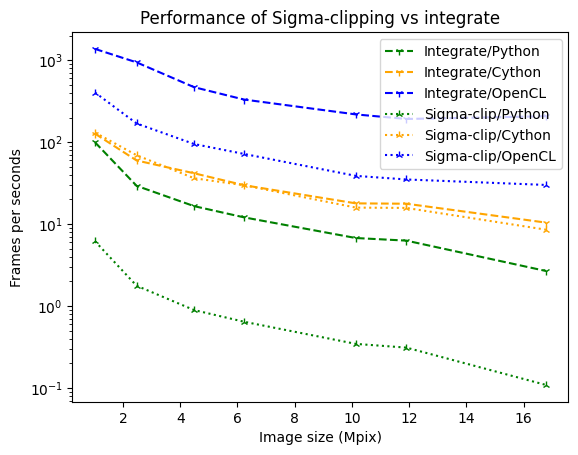

In [6]:
fig, ax = subplots()
ax.set_xlabel("Image size (Mpix)")
ax.set_ylabel("Frames per seconds")
sizes = numpy.array(list(perfs_integrate_python.keys()))/1e6
ax.plot(sizes, [1/i.best for i in perfs_integrate_python.values()], label="Integrate/Python", color='green', linestyle='dashed', marker='1')
ax.plot(sizes, [1/i.best for i in perfs_integrate_cython.values()], label="Integrate/Cython", color='orange', linestyle='dashed', marker='1')
ax.plot(sizes, [1/i.best for i in perfs_integrate_opencl.values()], label="Integrate/OpenCL", color='blue', linestyle='dashed', marker='1')
ax.plot(sizes, [1/i.best for i in perfs_sigma_clip_python.values()], label="Sigma-clip/Python", color='green', linestyle='dotted', marker='2')
ax.plot(sizes, [1/i.best for i in perfs_sigma_clip_cython.values()], label="Sigma-clip/Cython", color='orange', linestyle='dotted', marker='2')
ax.plot(sizes, [1/i.best for i in perfs_sigma_clip_opencl.values()], label="Sigma-clip/OpenCL", color='blue', linestyle='dotted', marker='2')
ax.set_yscale("log")
ax.legend()

ax.set_title("Performance of Sigma-clipping vs integrate");

The penalties is very limited in Cython, much more in Python.

The biggest limitation of sigma-clipping is its incompatibility with pixel-splitting, feature needed when oversampling, i.e. taking many more points than the size of the diagonal of the image.
While oversampling is not recommended in general case (due to the cross-corelation between bins it creates), it can be a nessessary evil, especially when performing Rietveld refinement where 5 points per peaks are needed, resolution that cannot be obtained with the pixel-size/distance couple accessible by the experimental setup.

## Median filter in Azimuthal space

The idea is to sort all pixels contibuting to an azimuthal bin and to average out all pixel between the lower and upper quantile. 
When those two thresholds are at one half, this filter provides actually the median.
In order to be compatible with pixel splitting, each pixel is duplicated as many times as it contributes to different bins.
After sorting fragments of pixels according to their normalization corrected signal, the cummulative sum of normalization is performed in order to detemine which fragments to average out.


In [7]:
ai = pyFAI.load(UtilsTest.getimage("Pilatus6M.poni"))
img = fabio.open(UtilsTest.getimage("Pilatus6M.cbf")).data

method = ["full", "csr", "cython"]
percentile=(40,60)
pol=0.99

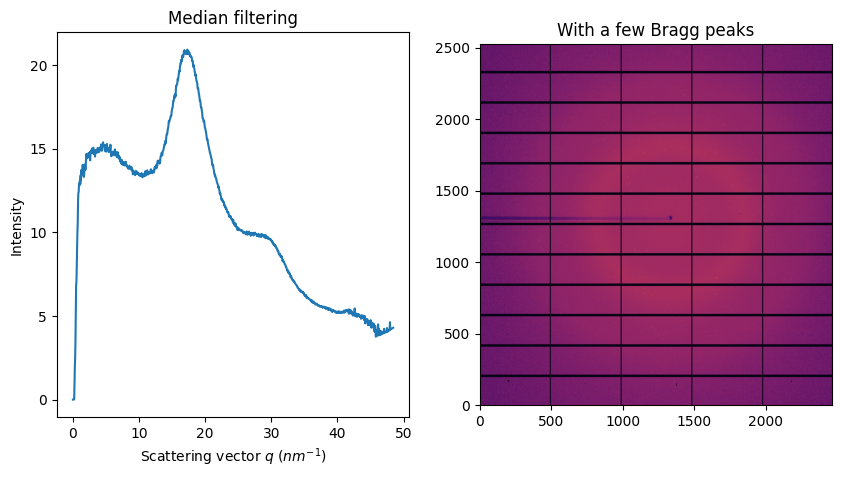

In [8]:
fig, ax = subplots(1, 2, figsize=figsize)
jupyter.display(img, ax=ax[1])
jupyter.plot1d(ai.medfilt1d_ng(img, 1000, method=method, percentile=percentile, polarization_factor=pol), ax=ax[0])
ax[1].set_title("With a few Bragg peaks")
ax[0].set_title("Median filtering");

Unlike the *sigma-clipping*, this median filter does not equires any error model; but the computationnal cost induced by the sort is huge. In addition, the median is very sensitive and requires a good geometry and modelisation of the polarization.

In [9]:
%%time 
perf2_integrate_python = {}
perf2_integrate_cython = {}
perf2_integrate_opencl = {}
perf2_medfilt_python = {}
perf2_medfilt_cython = {}
perf2_medfilt_opencl = {}

for ds in pyFAI.benchmark.PONIS:
    ai = pyFAI.load(UtilsTest.getimage(ds))
    if ai.wavelength is None: ai.wavelength=1.54e-10
    img = fabio.open(UtilsTest.getimage(pyFAI.benchmark.datasets[ds])).data
    size = numpy.prod(ai.detector.shape)
    print(ds)
    print("     Cython")
    meth = tuple(method)
    nbin = max(ai.detector.shape)
    print("     * integrate   ", end="")
    perf2_integrate_cython[size] = %timeit -o ai.integrate1d(img, nbin, method=meth)
    print("     * medianfilter", end="")
    perf2_medfilt_cython[size] = %timeit -o ai.medfilt1d_ng(img, nbin, method=meth)
    print("     Python")
    meth = tuple(method[:2]+["python"])
    print("     * integrate   ", end="")
    perf2_integrate_python[size] = %timeit -o ai.integrate1d(img, nbin, method=meth)
    print("     * medianfilter", end="")
    perf2_medfilt_python[size] = %timeit -o ai.medfilt1d_ng(img, nbin, method=meth)

    print("     OpenCL")
    meth = tuple(method[:2]+["opencl"])
    print("     * integrate   ", end="")
    perf2_integrate_opencl[size] = %timeit -o ai.integrate1d(img, nbin, method=meth)
    print("     * medianfilter", end="")
    perf2_medfilt_opencl[size] = %timeit -o ai.medfilt1d_ng(img, nbin, method=meth)

Pilatus1M.poni
     Cython
     * integrate   15.8 ms ± 4.35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     * medianfilter24.5 ms ± 542 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
     Python
     * integrate   13.1 ms ± 115 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
     * medianfilter1.24 s ± 1.48 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     OpenCL
     * integrate   710 μs ± 777 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
     * medianfilter9.42 ms ± 19.5 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Pilatus2M.poni
     Cython
     * integrate   17.5 ms ± 2.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     * medianfilter68.2 ms ± 3.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
     Python
     * integrate   46.7 ms ± 639 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
     * medianfilter4.25 s ± 5.77 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     OpenCL
     * in

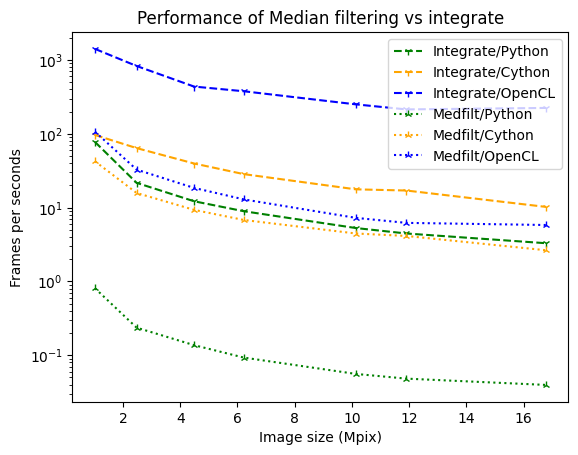

In [10]:
fig, ax = subplots()
ax.set_xlabel("Image size (Mpix)")
ax.set_ylabel("Frames per seconds")
sizes = numpy.array(list(perf2_integrate_python.keys()))/1e6
ax.plot(sizes, [1/i.best for i in perf2_integrate_python.values()], label="Integrate/Python", color='green', linestyle='dashed', marker='1')
ax.plot(sizes, [1/i.best for i in perf2_integrate_cython.values()], label="Integrate/Cython", color='orange', linestyle='dashed', marker='1')
ax.plot(sizes, [1/i.best for i in perf2_integrate_opencl.values()], label="Integrate/OpenCL", color='blue', linestyle='dashed', marker='1')
ax.plot(sizes, [1/i.best for i in perf2_medfilt_python.values()], label="Medfilt/Python", color='green', linestyle='dotted', marker='2')
ax.plot(sizes, [1/i.best for i in perf2_medfilt_cython.values()], label="Medfilt/Cython", color='orange', linestyle='dotted', marker='2')
ax.plot(sizes, [1/i.best for i in perf2_medfilt_opencl.values()], label="Medfilt/OpenCL", color='blue', linestyle='dotted', marker='2')
ax.set_yscale("log")
ax.legend()
ax.set_title("Performance of Median filtering vs integrate");

As one can see, the penalities are much larger for OpenCL and Python than for Cython.

## Conclusion
*Sigma-clipping* and *median-filtering* are alternatives to azimuthal integration and offer the ability to reject outliers. They are not more difficult to use but slightly slower owing to their greater complexity.